# Uni-Mol BBB premeability prediction

<a href="https://colab.research.google.com/github/LicoriceLin/NMDA_deeplearning_example/blob/master/unimol-demo-only-infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up the Environments

In [ ]:
# @markdown **execute this block to set-up your environment.<br>**
# @markdown in your own worksite, this block could be executed once for all.
%%bash

export NCCL_ASYNC_ERROR_HANDLING=1
export OMP_NUM_THREADS=1

cd /content
GIT_REPO='https://github.com/LicoriceLin/Uni-Mol.git'
UNICORE_URL='https://github.com/dptech-corp/Uni-Core/releases/download/0.0.2/unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl'
WEIGHT_URL='https://github.com/LicoriceLin/NMDA_deeplearning_example/releases/download/0.0.1/demo_bbb_model.pt'
if [ ! -f UNIMOL_READY ]; then
  wget -q ${UNICORE_URL}
  pip3 -q install "unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl"
  git clone -b main ${GIT_REPO}
  cd ./Uni-Mol/unimol
  python setup.py develop
  cd -
  pip install -q rdkit
  pip install -q biopandas
  pip install -q py3Dmol
  git clone https://github.com/LicoriceLin/NMDA_deeplearning_example.git
  wget -q ${WEIGHT_URL}
  touch UNIMOL_READY
fi

# Inference
if you already have the .pt model file,<br>
you could skip all protocols above to run inference,
## Parameter



<!-- ### `task_type`
 regression or classification

### `num_classes`
 How many class in claasification task.<br>
 Set to `1` in regression task. -->

### `data_path`
Acceptable data could be:
 1.  a .csv file (from Excel or any text editor).<br>
 its 1st columns is the smiles string of
 your molelules,<br>
 and the 2rd colum is the target function.
 to fit on(integers or decimals).<br>
 this code will automatically split your input
 into train/valid/test set
 with a ratio of 8:1:1

 2. a folder contains three files: {train,valid,test}.csv.<br>
 all of them should cpmply with the above format.

 3. a folder contains three files: {train,valid,test}.lmdb.<br>
 turn on `skip_preprocess` in this case

<!-- ### `seed`
 Random seed (integer) to split train/valid/test set and generate conformation.

### `infer_weight_path`
path to trained model

### `only_polar`
corresponding to your pretrained model

### `norm_path`
path to .norm file in regression. omit in classification. -->


NOTE:<br>
you may not don't have the ground truth value of you data,<br>
but you must impute a columns of ground truth of pseudo values <br>
(e.g., all zeros).



In [ ]:
# @markdown **execute this block to run predictions.**
task_type='classification' 
num_classes=2 
data_path='/content/NMDA_deeplearning_example/bbb_data/test.lmdb' # @param {type:"string"}
infer_weight_path='/content/NMDA_deeplearning_example.git'
only_polar=0 
norm_path='/content/NMDA_deeplearning_example/qsar_data/.norm' 
seed=42
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'
batch_size=16


import pandas as pd
from glob import glob
import re,os,shutil
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve,
                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)

def sort_key(s):
    match = re.match(r'([\w/]+checkpoint)((\d+)|(_.+))\.pt', s)
    if match:
        prefix = match.group(1)
        if match.group(2).startswith('_'):
            return (1, match.group(2))

        else:
            return (0, int(match.group(2)))
    return (2, s)

def split_testfile(test_file:str):
    _,subset=os.path.split(test_file)
    subset=subset.replace('.lmdb','')
    result_path=os.path.join(_,subset+'_result')
    data_path,task_name=os.path.split(_)
    return data_path,task_name,subset,result_path

def split_list_col(df:pd.DataFrame,column_to_split:str):
    where_column_to_split=df.columns.get_loc(column_to_split)
    column_data = df.pop(column_to_split)
    try:
      try:
        len_column_data=len(column_data[0])
      except:
        len_column_data=1
      split_columns = pd.DataFrame(column_data.tolist(),
                        columns=[f'{column_to_split}_{i + 1}'
                        for i in range(len_column_data)])
    except:
      import pdb;pdb.set_trace()
    df_out = pd.concat([df.iloc[:, :where_column_to_split],
                        split_columns, df.iloc[:, where_column_to_split:]], axis=1)
    return df_out

def get_csv_results(predict_path):
  predict = pd.read_pickle(predict_path)
  smi_list, predict_list,target_list = [], [], []
  for batch in predict:
      sz = batch["bsz"]
      infer_name='prob' if task_type=='classification' else 'predict'
      for i in range(sz):
        smi_list.append(batch["smi_name"][i])
        predict_list.append(batch[infer_name][i].tolist())
        target_list.append(batch['target'][i].tolist())
  predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list,"target":target_list})
  predict_df=split_list_col(predict_df,"predict")
  if task_type=='regression':
    predict_df=split_list_col(predict_df,"target")

  predict_df = predict_df.groupby("SMILES")[
      [i for i in predict_df if i !='SMILES']].mean().reset_index()
  predict_df.to_csv(predict_path.replace('.out.pkl','.full.csv'),index=False)

  if task_type=='classification':
    demo_predict_list = [i[1] for i in predict_list]
    demo_target_list = [i for i in target_list]
  else:
    demo_predict_list = [i[0] for i in predict_list]
    demo_target_list = [i[0] for i in target_list]
  demo_predict_df = pd.DataFrame({"SMILES": smi_list, "predict":demo_predict_list ,"target":demo_target_list})
  demo_predict_df = demo_predict_df.groupby("SMILES")[["predict","target"]].mean().reset_index()
  demo_predict_df.to_csv(predict_path.replace('.out.pkl','.csv'),index=False)
  return demo_predict_df


if task_type=='regression' :
  loss_func="finetune_mse"
else:
  loss_func="finetune_cross_entropy"

conf_size=11

if task_type=='regression':
    with open(norm_path,'r') as f:
        ls=f.readlines()
        mean=float(ls[0].strip('mean: '))
        std=float(ls[1].strip('std: '))
    infer_extra_paras=f"--customized-regression --mean '{mean}' --std '{std}' "
else:
    infer_extra_paras=''

if data_path.endswith('.lmdb'):
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(data_path)
elif data_path.endswith('.csv'):
  _=data_path.replace('.csv','.lmdb')
  if not os.path.isfile(_):
    flags=f'-data {data_path} --seed {seed}'
    !python NMDA_deeplearning_example/preprocess.py $flags
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(_)
else:
  raise ValueError

id=os.path.basename(infer_weight_path).replace('.pt','')
flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {test_data_path} \
  --task-name {test_task_name} --valid-subset {test_subset} \
  --results-path {test_result_path} \
  --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
  --task mol_finetune --loss {loss_func} --arch unimol_base \
  --classification-head-name {test_task_name} --num-classes {num_classes} \
  --dict-name {dict_name} --conf-size {conf_size} \
  --only-polar {only_polar}  \
  --path {infer_weight_path}  \
  --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
  --log-interval 50 --log-format simple {infer_extra_paras}'''

!python /content/Uni-Mol/unimol/unimol/infer.py $flags

fname = infer_weight_path.split("/")[-2]
save_path = os.path.join(test_result_path,
        fname + "_" + test_subset + ".out.pkl")
tmp_save_path=save_path.replace(".out.pkl",f".{id}.out.pkl")
shutil.move(save_path,tmp_save_path)
infer_result=get_csv_results(tmp_save_path)

In [38]:
# @markdown **execute this block to check your predictions in a table.**
infer_result

,SMILES,predict,target
0,C(C(C(CC)C)C(N)=O)C,0.999875,1.0
1,C(C(C(N)=O)(CCC)CCC)CC,0.999872,1.0
2,C(C(CCCC)CC)NC(CC(C)O)=O,0.999830,1.0
3,C(C1(C(NC(=O)NC1=O)=O)C(C)C)C=C,0.999815,1.0
4,C(C2C1C(NC(N1)=O)CS2)CCCC(O)=O,0.005276,1.0
...,...,...,...
201,c1(ccc(c(c1)Cl)Cl)CC(N1[C@@H](c2c(CC1)[nH]cn2)...,0.999196,0.0
202,c1(ccc(c(c1)Cl)Cl)CC(N1[C@H](C[N@@]2C[C@@H](CC...,0.001061,0.0
203,c1ccc(C(NCCCOc2cc(CN3CCCCC3)ccc2)=O)cc1,0.999848,1.0
204,c1ccc2Oc3c(cc(cc3)Cl)[C@@H]3[C@@H](c2c1)C[N@](...,0.999858,1.0


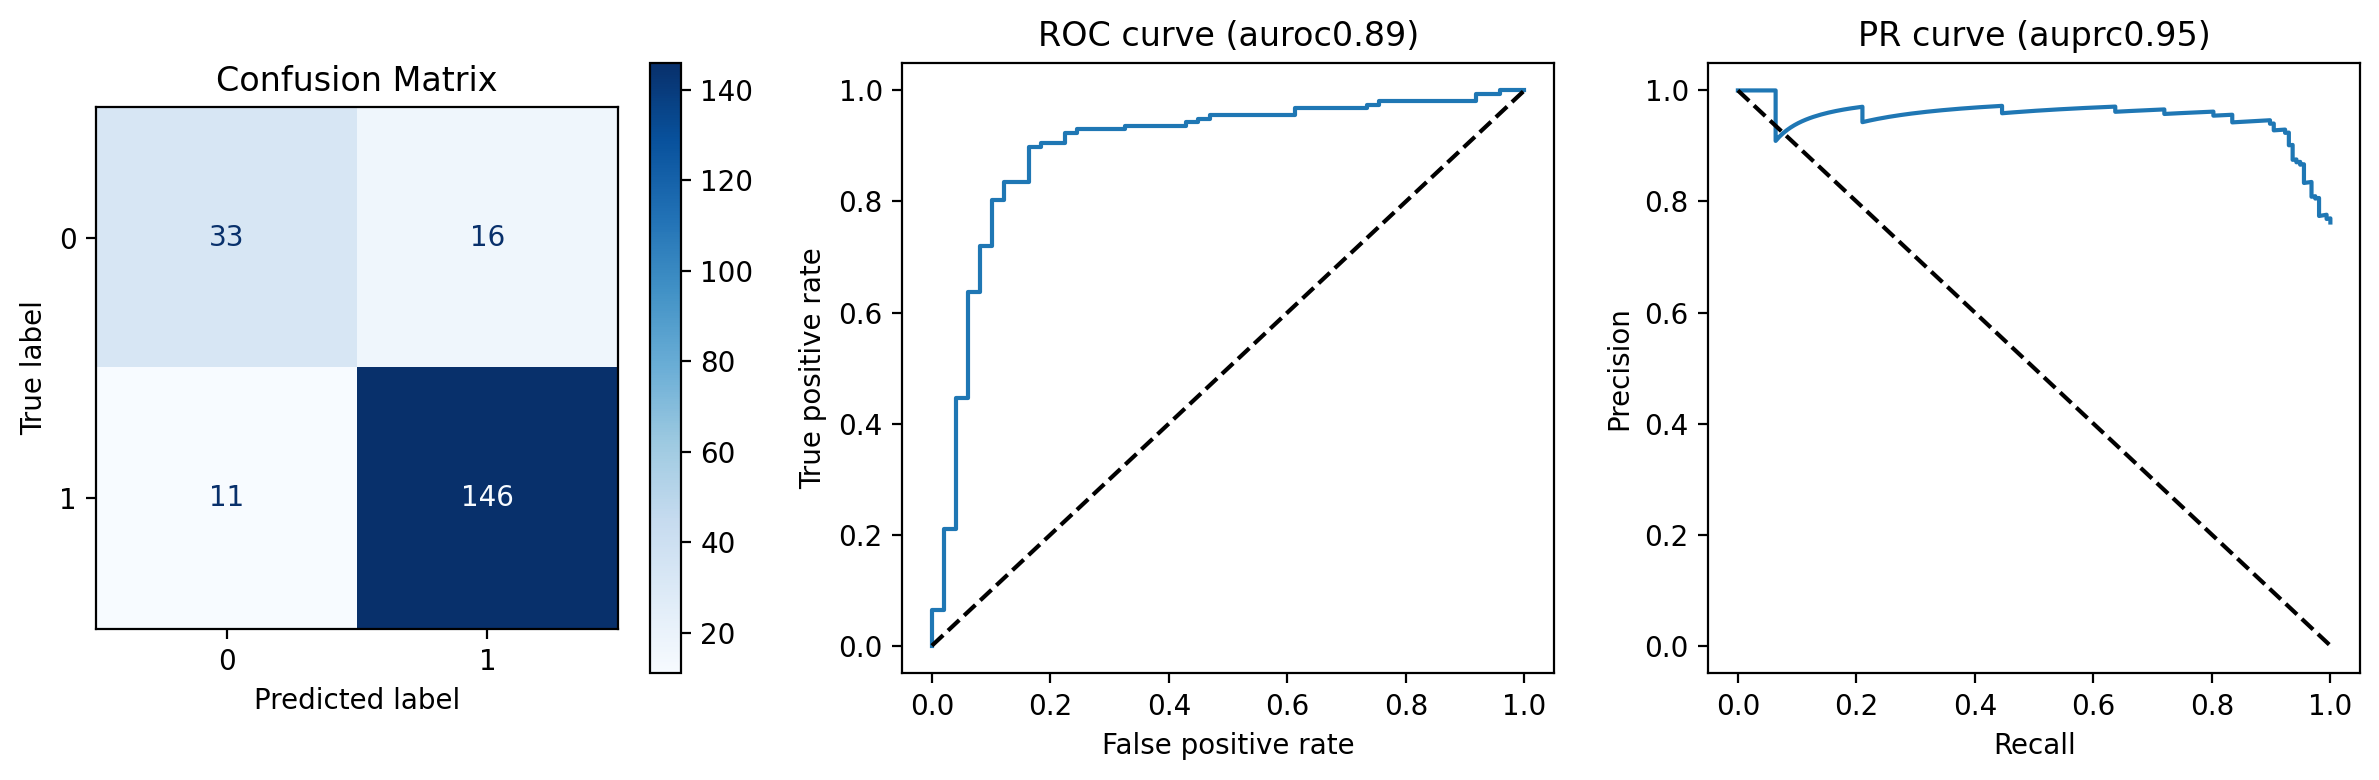

In [39]:
# @markdown **execute this block to plot your prediction.**
if task_type=='regression':
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    axes.scatter(infer_result['target'], infer_result['predict'])
    min_max_ = [infer_result['target'].min(),infer_result['target'].max()]
    axes.plot(min_max_,min_max_,'--',c='grey',label='x=y')

    axes.set_xlabel('target')
    axes.set_ylabel('predict')
    r = r2_score(df['predict'],df['target'])
    rmse = mean_squared_error(df['predict'],df['target'])
    axes.set_title(f'rmse{rmse:.2f}')
    fig.set_dpi(200)
else:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fpr, tpr, _ = roc_curve(infer_result['target'], infer_result['predict'])


    pred_label = [1 if i > 0.1 else 0 for i in infer_result['predict']]
    cm = confusion_matrix(infer_result['target'], pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap='Blues', values_format='.0f',ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    axes[1].plot(fpr, tpr)
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel('False positive rate')
    axes[1].set_ylabel('True positive rate')
    auroc = roc_auc_score(infer_result['target'], infer_result['predict'])
    axes[1].set_title(f'ROC curve (auroc{auroc:.2f})')

    auprc = average_precision_score(
        infer_result['target'], infer_result['predict'])
    precision, recall, _ = precision_recall_curve(
        infer_result['target'], infer_result['predict'])
    axes[2].plot(recall, precision, label=f"PR curve (AUPRC={auprc:.2f})")
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title(f'PR curve (auprc{auprc:.2f})')
    axes[2].plot([0, 1], [1, 0], 'k--')

    fig.set_dpi(200)
plt.tight_layout()
plt.show()